In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader # lets us load data in batches
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy
import shutil
from sklearn.model_selection import train_test_split

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset
dataset_dir = '/content/drive/My Drive/sih_road_dataset'
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

In [6]:
print("Classes in the dataset:")
for idx, class_name in enumerate(dataset.classes):
    print(f"Class {idx}: {class_name}")

Classes in the dataset:
Class 0: good
Class 1: poor
Class 2: satisfactory
Class 3: very_poor


In [7]:
# Get all indices
indices = list(range(len(dataset)))

# Split indices into train and remaining
train_indices, remaining_indices = train_test_split(
    indices, test_size=0.21, random_state=42, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    remaining_indices, test_size=0.5, random_state=42, stratify=[dataset.targets[i] for i in remaining_indices]
)

In [8]:
print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

1383
184
184


In [9]:
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Buat DataLoader untuk train dan test set
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [10]:
image, label = train_dataset[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 256, 256]) 
Label: 1


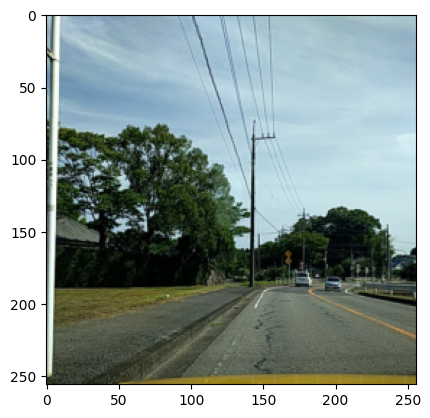

In [11]:
image = image.permute(1, 2, 0)
plt.imshow(image);

In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Adjusted based on output size
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)  # Number of classes

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = F.relu(self.conv3(X))
        X = self.pool(X)
        X = F.relu(self.conv4(X))
        X = self.pool(X)

        X = X.view(-1, 128 * 16 * 16)  # Flatten the tensor
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [13]:
for i, (X_train, y_train) in enumerate(train_dataset):
  break

In [14]:
X_train

tensor([[[0.6588, 0.6745, 0.6863,  ..., 0.6392, 0.6353, 0.6353],
         [0.6627, 0.6863, 0.6863,  ..., 0.6510, 0.6471, 0.6471],
         [0.6667, 0.6863, 0.6902,  ..., 0.6588, 0.6510, 0.6510],
         ...,
         [0.2196, 0.1843, 0.1451,  ..., 0.5294, 0.5294, 0.5255],
         [0.1294, 0.1804, 0.1961,  ..., 0.5490, 0.5490, 0.5412],
         [0.1725, 0.2157, 0.1843,  ..., 0.5529, 0.5647, 0.5569]],

        [[0.7686, 0.7765, 0.8000,  ..., 0.7608, 0.7569, 0.7569],
         [0.7686, 0.7882, 0.7961,  ..., 0.7725, 0.7647, 0.7647],
         [0.7686, 0.7843, 0.8000,  ..., 0.7725, 0.7647, 0.7647],
         ...,
         [0.2471, 0.2118, 0.1725,  ..., 0.4627, 0.4588, 0.4588],
         [0.1569, 0.2078, 0.2235,  ..., 0.4745, 0.4784, 0.4745],
         [0.2000, 0.2392, 0.2118,  ..., 0.4745, 0.4863, 0.4863]],

        [[0.7922, 0.8039, 0.8235,  ..., 0.7804, 0.7765, 0.7765],
         [0.7961, 0.8118, 0.8196,  ..., 0.7922, 0.7882, 0.7922],
         [0.7961, 0.8118, 0.8235,  ..., 0.8000, 0.7961, 0.

In [15]:
X_train.shape

torch.Size([3, 256, 256])

In [16]:
torch.manual_seed(42)
model = ConvolutionalNetwork()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [17]:
for param in model.parameters():
  print(param.numel())  #numel=number of elements/parameters

432
16
4608
32
18432
64
73728
128
16777216
512
65536
128
512
4


In [18]:
criterion = nn.CrossEntropyLoss() #karena multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #learning rate

In [19]:
# Training and Testing
start_time = time.time()
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 91 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{18*b:6}/1638]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(18*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Testing
    model.eval()
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            y_result = model(X_val)
            predicted = torch.max(y_result.data, 1)[1]
            tst_corr += (predicted == y_val).sum()

    loss = criterion(y_result, y_val)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

    current_time = time.time()
    total = current_time - start_time
print(f'\nDuration: {total/60:.2f} minutes')


Duration: 30.79 minutes


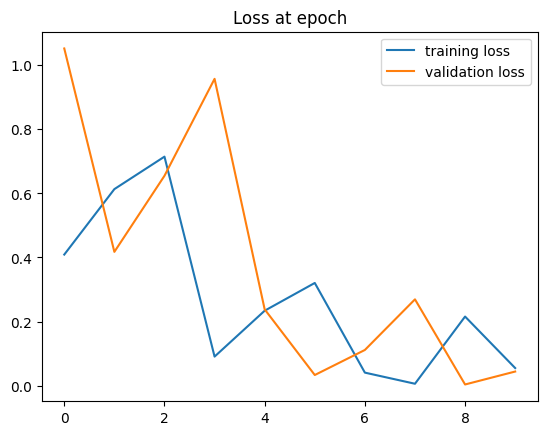

In [20]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at epoch')
plt.legend();

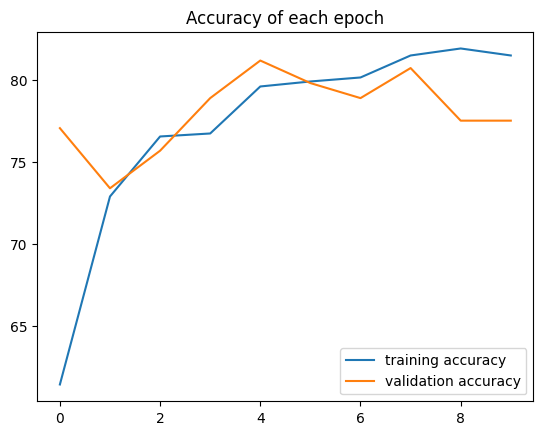

In [21]:
plt.plot([(t*100/1638) for t in train_correct], label='training accuracy')
plt.plot([(t*100/218) for t in test_correct], label='validation accuracy')
plt.title('Accuracy of each epoch')
plt.legend();

In [22]:
test_load_all = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [23]:
with torch.no_grad():  # Don't update weights or biases in test data
    correct = 0
    total = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # Forward pass
        _, predicted = torch.max(y_val, 1)  # Get predicted class indices
        correct += (predicted == y_test).sum().item()  # Count correct predictions
        total += y_test.size(0)  # Count total samples

# Print accuracy
accuracy = (correct / total) * 100
print(f'Test accuracy: {correct}/{total} = {accuracy:.2f}%')

Test accuracy: 165/184 = 89.67%


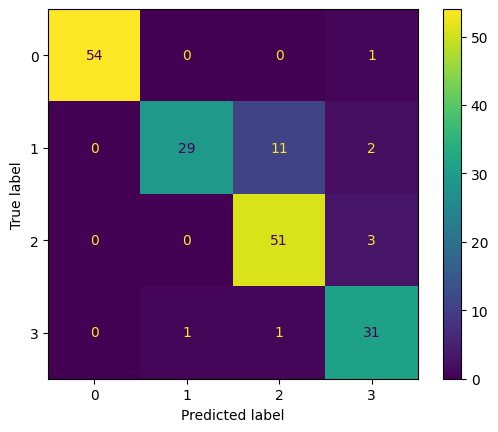

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

all_predictions = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        _, predicted = torch.max(y_val, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))
disp.plot()
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute classification report
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(4)])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99        55
     Class 1       0.97      0.69      0.81        42
     Class 2       0.81      0.94      0.87        54
     Class 3       0.84      0.94      0.89        33

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.89       184
weighted avg       0.91      0.90      0.89       184



In [26]:
from torchvision import models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [28]:
start_time = time.time()
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 91 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{18*b:6}/1638]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(18*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Testing
    model.eval()
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            y_result = model(X_val)
            predicted = torch.max(y_result.data, 1)[1]
            tst_corr += (predicted == y_val).sum()

    loss = criterion(y_result, y_val)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())
    current_time = time.time()
    total = current_time - start_time
print(f'\nDuration: {total/60:.2f} minutes')



Duration: 39.36 minutes


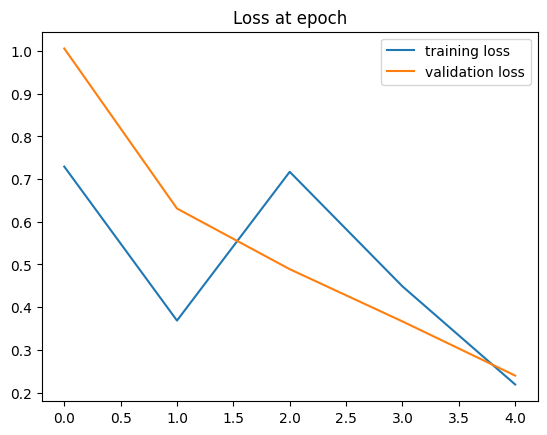

In [29]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at epoch')
plt.legend();

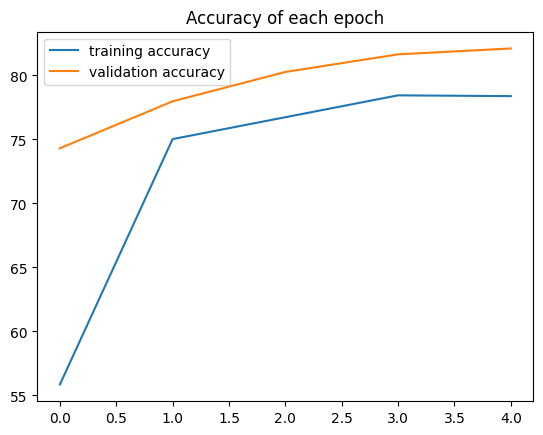

In [30]:
#accuracy at each epoch
plt.plot([(t*100/1638) for t in train_correct], label='training accuracy')
plt.plot([(t*100/218) for t in test_correct], label='validation accuracy')
plt.title('Accuracy of each epoch')
plt.legend();

In [31]:
test_load_all = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [32]:
with torch.no_grad():  # Don't update weights or biases in test data
    correct = 0
    total = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # Forward pass
        _, predicted = torch.max(y_val, 1)  # Get predicted class indices
        correct += (predicted == y_test).sum().item()  # Count correct predictions
        total += y_test.size(0)  # Count total samples

# Print accuracy
accuracy = (correct / total) * 100
print(f'Test accuracy: {correct}/{total} = {accuracy:.2f}%')

Test accuracy: 167/184 = 90.76%


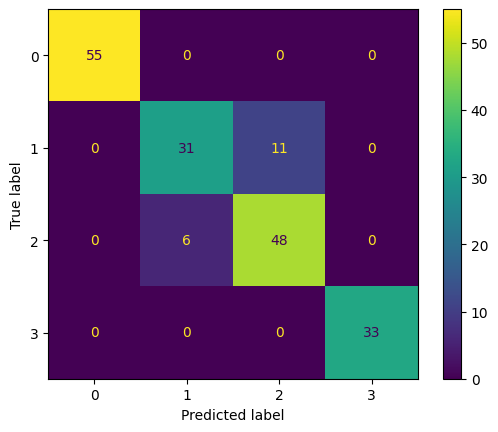

In [33]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        _, predicted = torch.max(y_val, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))
disp.plot()
plt.show()

In [34]:
# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute classification report
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(4)])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        55
     Class 1       0.84      0.74      0.78        42
     Class 2       0.81      0.89      0.85        54
     Class 3       1.00      1.00      1.00        33

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

